**Assignment 2** Detoxification for Russian text


**Name: Prateek Rajput**


Codalab Username: pkrajput7 


**Intorduction**

We approach a style transfer task for text detoxification in Russian language. This task can be approached in multiple ways but I used a seq2seq transformer model using encoding decoding approach. I used the ruT5 base paraphraser [cointegrated/rut5-base-paraphraser](https://huggingface.co/cointegrated/rut5-base-paraphraser) and trained it on a pairwise training dataset. Other approaches like word replacement whist keeping the content intact can also be targetting using transformers but those have the drawback of losing information though they perform well on content preservation.

I analysed this model for toxicity and severe toxicity conpared to the initial dataset using [this github implementation](https://github.com/unitaryai/detoxify). It also considers other metrics like obsenity, threat, identity attack and sexually explicit content but for this report I just focus on the before mentioned two. 

At last I also analysed the content preservation via simple dot product similarity metric of the processed and unprocessed data sets using vector embeddings from [cointegrated/LaBSE-en-ru](https://huggingface.co/cointegrated/LaBSE-en-ru) to see if the encoding is close in content to our origional text while the style has now been reformed.

**Methodology**

###1 
The training set consists of approx 15000 pairs for toxic and neutral text. I split the data into training and validation sets keeping just 300 examples for the validation set.
###2
I used the T5Tokenizer and T5conditional generator to tokenize and generate decodings respectively, paired the toxic and neutral strings using torch and analysed the initial loss for a chosen small batch from the dataset which was found to be $\approx$ 4.35
###3
After testing the initial loss and initial output of the seq2seq model I trained it for 3 epochs each for 500 steps and the final loss came to be $\approx$ 0.701
###4
I then saved the output for our input test dataset in the test_neutral.txt file which I renamed as results.txt for the final submission and plotted graphs for the toxic text vs neutral text for "toxicity" and "severe toxicity" based on the transformer model github repository as mentioned in the introduction for the first size(samples)/100 samples. I chose a smaller subset to plot as I was facing RAM overflow issues while exploring the whole dataset
###5
At last I also plotted the content similarity between the tranformed text and the origional text based on the dot product of embeddings and the average for first 25 samples to check if the divergence from initial content is not too much.

In [1]:
from pandas import *

In [2]:
data = read_csv("toxic_neutral.csv")

In [3]:
toxic_text = data['toxic'].tolist()
neutral_text = data['neutral'].tolist()

In [4]:
toxic = [s.strip() for s in toxic_text]
neutral = [s.strip() for s in neutral_text]

In [5]:
print(toxic[0])
print(neutral[0])

Я не собираюсь продавать эту гребаную картинку, я просто хочу внести свой вклад в эту гребаную статью.
Я не собираюсь продавать картину, я просто хочу внести свой вклад в статью.


In [6]:
!pip install transformers sentencepiece

     |████████████████████████████████| 3.3 MB 7.7 MB/s 
     |████████████████████████████████| 1.2 MB 65.4 MB/s 
     |████████████████████████████████| 596 kB 81.3 MB/s 
     |████████████████████████████████| 3.3 MB 86.2 MB/s 
     |████████████████████████████████| 895 kB 76.4 MB/s 
     |████████████████████████████████| 61 kB 631 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange 
#importing tokenizer and generator functions

import torch
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast
)

In [8]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [9]:
import random
random.seed(10)

for idx in random.sample(range(len(toxic)), 5):
  print(f"TOXIC:  {toxic[idx]}")
  print(f"NEUTRAL:    {neutral[idx]}")
  print()

TOXIC:  "подожди, дерьмо, значит, мой парень и я женаты?
NEUTRAL:    "подожди, значит, мы с моим парнем женаты?

TOXIC:  Я бы охарактеризовал вас как скупца.
NEUTRAL:    Я бы охарактеризовал вас как человека, который не любит тратить

TOXIC:  что ты копаешь древнюю гребаную историю для своей тупой пизды?. ты чертовски отчаялся!. edl
NEUTRAL:    что ты копаешь для себя древнюю историю?. ты в отчаянии

TOXIC:  где, черт возьми, моя пасхальная корзинка!. !. !. !. !. !
NEUTRAL:    Где моя пасхальная корзинка? !!

TOXIC:  прочтите статью перед тем, как выкладывать дерьмо.
NEUTRAL:    Прочтите статью перед публикацией.



In [10]:
model_name = "cointegrated/rut5-base-paraphraser"
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda:0")
model.to(device);

Downloading:   0%|          | 0.00/808k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/315 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/724 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/932M [00:00<?, ?B/s]

In [11]:
# output funtion performing beam search to those the best option


def paraphrase(
    text,
    model, 
    tokenizer,
    max_length='auto', beams=3,
    do_sample=False, temperature=1.0, repetition_penalty=3.0, bad_words_ids=[[2]],
    verbose=False,
    **kwargs
):
    """
    :text: one string or list of strings that would be processed
    :model: the model for translation ("toxic to neutral")
    :tokenizer: must be the same tokenizer that was used to train the model
    """
    texts = [text] if isinstance(text, str) else text
    inputs = tokenizer(texts, return_tensors='pt', padding=True)['input_ids'].to(model.device)
    if max_length == 'auto':
        max_length = max(int(inputs.shape[1] * 1.2) + 10, 64)
    attempts = beams
    out = model.generate(
        inputs, 
        num_beams=beams,
        num_return_sequences=attempts, 
        do_sample=do_sample, 
        temperature=temperature, 
        repetition_penalty=repetition_penalty, 
        max_length=max_length,
        bad_words_ids=bad_words_ids,  # unk
        output_scores=True, 
        return_dict_in_generate=True,
        **kwargs
    )
    results = [tokenizer.decode(r, skip_special_tokens=True) for r in out.sequences]
    
    if verbose:
        print(results)

    out_texts = []
    for i in range(len(texts)):
        out_texts.append(results[i*attempts])
    return out_texts

In [12]:
# split our training data into train and validation

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    toxic,
    neutral,
    test_size=300,
    random_state=1
    )

In [13]:
class PairsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        assert idx < len(self.x['input_ids'])
        item = {key: val[idx] for key, val in self.x.items()}
        item['decoder_attention_mask'] = self.y['attention_mask'][idx]
        item['labels'] = self.y['input_ids'][idx]
        return item

    def __len__(self):
        return len(self.x['input_ids'])

In [14]:
# tokenize sentences
x1 = tokenizer(list(X_train))
y1 = tokenizer(list(y_train))
x2 = tokenizer(list(X_val))
y2 = tokenizer(list(y_val))

# build torch Dataset Pairings
train_dataset = PairsDataset(x1, y1)
val_dataset = PairsDataset(x2, y2)
len(train_dataset), len(val_dataset)

(15182, 300)

In [15]:
from typing import List, Dict, Union

class DataCollatorWithPadding:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        batch = self.tokenizer.pad(
            features,
            padding=True,
        )
        ybatch = self.tokenizer.pad(
            {'input_ids': batch['labels'], 'attention_mask': batch['decoder_attention_mask']},
            padding=True,
        ) 
        batch['labels'] = ybatch['input_ids']
        batch['decoder_attention_mask'] = ybatch['attention_mask']
        
        return {k: torch.tensor(v) for k, v in batch.items()}

In [16]:
batch_size = 16
gradient_accumulation_steps = 2
window = 100
cleanup_step = 200
report_step = 500

optimizer = torch.optim.Adam(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=1e-5
)

In [17]:
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=data_collator,
    shuffle=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=data_collator,
    shuffle=False,
)

In [18]:
#initial loss of our model
def evaluate_model(model, test_dataloader):
    num = 0
    den = 0

    for batch in test_dataloader:
        with torch.no_grad():
            loss = model(**{k: v.to(model.device) for k, v in batch.items()}).loss
            num += len(batch) * loss.item()
            den += len(batch)
    val_loss = num / den
    return val_loss

print(evaluate_model(model, val_dataloader))

4.350582976090281


In [19]:
#initial test for a manual input
paraphrase(
    ["Пизда, дай мне это полотенце, ты испортил девушку"],
    beams=1,
    model=model,
    tokenizer=tokenizer
)

['Пизда, дай мне это полотенце']

In [20]:
ewm_loss = 0
model.train()
#3 epoch training for the encoder decoder model
for epoch in trange(3):  
    tq = tqdm(train_dataloader)
    for i, batch in enumerate(tq):
        try:
            loss = model(**{k: v.to(model.device) for k, v in batch.items()}).loss
            loss.backward()
        except RuntimeError as e:
            print('error on step', i, e)
            loss = None
            cleanup()
            continue
        if i and i % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        if i % cleanup_step == 0:
            cleanup()

        w = 1 / min(i+1, window)
        ewm_loss = ewm_loss * (1-w) + loss.item() * w
        tq.set_description(f'loss: {ewm_loss:4.4f}')
        
        if i % report_step == 0:
            model.eval()
            eval_loss = evaluate_model(model, val_dataloader)
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {ewm_loss:4.4f}  val loss: {eval_loss:4.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

epoch 0, step 0: train loss: 5.0396  val loss: 4.3506
epoch 0, step 500: train loss: 0.8331  val loss: 0.6790


  0%|          | 0/949 [00:00<?, ?it/s]

epoch 1, step 0: train loss: 0.9157  val loss: 0.6447
epoch 1, step 500: train loss: 0.6970  val loss: 0.6227


  0%|          | 0/949 [00:00<?, ?it/s]

epoch 2, step 0: train loss: 0.6762  val loss: 0.6113
epoch 2, step 500: train loss: 0.6945  val loss: 0.6010


In [21]:
paraphrase(
    ["отвали, ты бесполезен, подонок", "Что за тупица не может сделать дерьмо"],
    beams=1,
    model=model,
    tokenizer=tokenizer
)

['Отвали, ты бесполезен', 'Что за хуйня не сможет']

In [22]:
with open("/content/test_dataset.txt", "r") as f:
  toxic_content = f.readlines()

In [74]:
with open("/content/dev_dataset.txt", "r") as g:
  toxic_content_dev = g.readlines()

In [75]:
toxic_to_neutral_dev = []
with open("test_neutral_dev.txt", "a") as g:

  for l in toxic_content_dev:
    g.write(paraphrase(
        [str(l)],
        beams=1,
        model=model,
        tokenizer=tokenizer)[0] + "\n"
    )
    


In [23]:
print(toxic_content[5])

мусор, создаваемый CNN и другими информационными агентствами, возмутителен.



In [24]:
toxic_to_neutral = []
with open("test_neutral.txt", "a") as g:

  for l in toxic_content:
    g.write(paraphrase(
        [str(l)],
        beams=1,
        model=model,
        tokenizer=tokenizer)[0] + "\n"
    )
    toxic_to_neutral.append((paraphrase(
        [str(l)],
        beams=1,
        model=model,
        tokenizer=tokenizer)[0]) 
    )  


In [25]:
pip install detoxify

In [26]:
from detoxify import Detoxify

In [27]:
#determining toxicity and severe toxicity metrics for the processed sequence 
toxicity_imp = []
severe_toxicity_imp = []
for i in range(int(len(toxic_to_neutral)/100)):
  toxicity_imp.append((Detoxify('multilingual').predict([toxic_to_neutral[i]])['toxicity'])[0])
  severe_toxicity_imp.append((Detoxify('multilingual').predict([toxic_to_neutral[i]])['severe_toxicity'])[0])

  
  

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.4-alpha/multilingual_debiased-0b549669.ckpt" to /root/.cache/torch/hub/checkpoints/multilingual_debiased-0b549669.ckpt


  0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [28]:
#determining toxicity and severe toxicity metrics for the test dataset sequences
toxicity = []
severe_toxicity = []
for i in range(int(len(toxic_to_neutral)/100)):
  toxicity.append((Detoxify('multilingual').predict([toxic_content[i]])['toxicity'])[0])
  severe_toxicity.append((Detoxify('multilingual').predict([toxic_content[i]])['severe_toxicity'])[0])

0.46452342914337097
0.8229316088274635


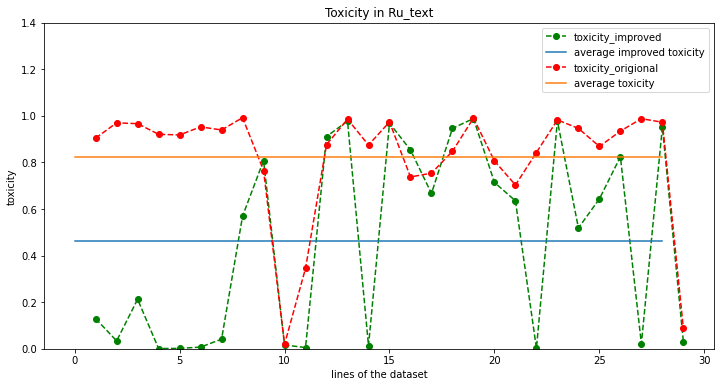

In [40]:
import matplotlib.pyplot as plt
n = int(len(toxic_to_neutral)/100)
x = np.arange(1,n+1)

plt.figure(figsize=(12, 6))

ax = plt.gca()
ax.set_ylim([0, 1.4])

plt.plot(x, toxicity_imp, linestyle= '--', marker = 'o', color = 'g', label = 'toxicity_improved')
plt.plot(np.arange(n), [np.average(toxicity_imp)]*n, label = "average improved toxicity")
print(np.average(toxicity_imp))
plt.plot(x, toxicity, linestyle= '--', marker = 'o',color = 'r', label = 'toxicity_origional')
plt.plot(np.arange(n), [np.average(toxicity)]*n, label = "average toxicity")
print(np.average(toxicity))
 
plt.xlabel('lines of the dataset')

plt.ylabel('toxicity')
 
plt.title('Toxicity in Ru_text')

plt.legend()
 
plt.show()

0.0007844218788046293
0.0013735396458851655


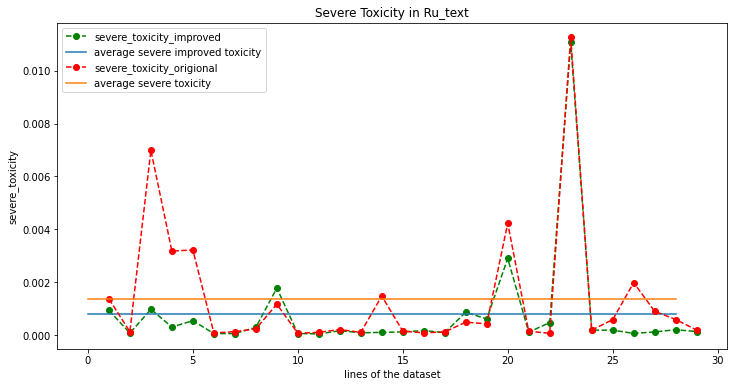

In [38]:
import matplotlib.pyplot as plt
n = int(len(toxic_to_neutral)/100)
x = np.arange(1,n+1)

plt.figure(figsize=(12, 6))
 
plt.plot(x, severe_toxicity_imp, linestyle= '--', marker = 'o', color = 'g', label = 'severe_toxicity_improved')
plt.plot(np.arange(n), [np.average(severe_toxicity_imp)]*n, label = "average severe improved toxicity")
print(np.average(severe_toxicity_imp))
plt.plot(x, severe_toxicity, linestyle= '--', marker = 'o',color = 'r', label = 'severe_toxicity_origional')
plt.plot(np.arange(n), [np.average(severe_toxicity)]*n, label = "average severe toxicity")
print(np.average(severe_toxicity))

plt.xlabel('lines of the dataset')

plt.ylabel('severe_toxicity')
 
plt.title('Severe Toxicity in Ru_text')

plt.legend()
 
plt.show()

In [31]:
#testing content preservation via dot product of embessings for the first 25 samples from toxic and transformed text
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")
dot = []
for i in range(25):
  sentences = [toxic_content[i], toxic_to_neutral[i]]
  encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=64, return_tensors='pt')
  with torch.no_grad():
      model_output = model(**encoded_input)
  embeddings = model_output.pooler_output
  embeddings = torch.nn.functional.normalize(embeddings)
 
  dot.append((np.dot(embeddings[0], embeddings[1])))
print(dot)

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[0.96017087, 0.7173503, 0.8839637, 0.857468, 0.6934985, 0.41525677, 0.8315583, 0.81262916, 0.92151594, 0.9890672, 0.79512966, 0.97810924, 0.9751547, 0.8507216, 0.97617733, 0.8439383, 0.92116296, 0.7525498, 0.9533334, 0.8361956, 0.940379, 0.7248497, 0.9859579, 0.801337, 0.84113497]


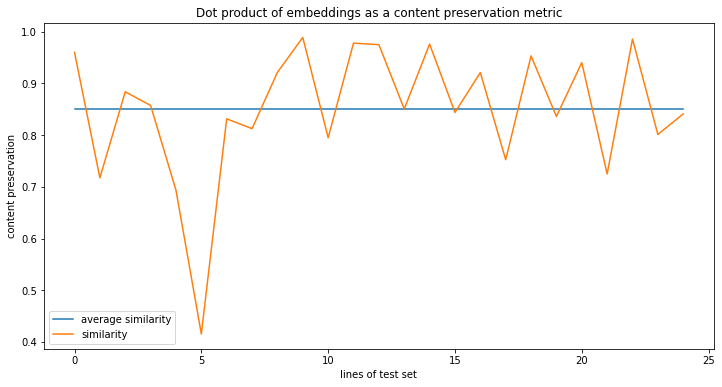

In [32]:
plt.figure(figsize=(12, 6))

plt.plot(np.arange(25), [np.average(dot)]*25, label = "average similarity")

plt.plot(np.arange(25), dot, label = "similarity")

plt.xlabel('lines of test set')

plt.ylabel('content preservation')
 
plt.title('Dot product of embeddings as a content preservation metric')

plt.legend()

plt.show()



**Results**
From the above generated images (I have attached the images with the .ipynb) we can notice the following:

###1
The average toxicity score for the first 29 elements fell from $\approx$ 0.8229 to $\approx$ 0.4645 which is a considerable improvement but still higher improvement can be achieved. I tried to fit the model for 6 epochs and submitted the dev set score on codalab which was also a slight improvement on this solution but it would also be interesting to use other methods like BERT to retreive or delete text.
###2
The average severe toxicity score fell from 0.00137 to 0.000784 
###3
The content retention based on dot product of embeddings between generated and toxic datasets was averaged around $\approx$ 0.84 



